# Severstal: Mask R-CNN tutorial for beginners
This tutorial covers a brief overview of Mask R-CNN and how to train a model from scratch using the Matterport Mask R-CNN implementation.

## Severstal: Steel Defect Detection
Steel is one of the most important building materials of modern times. Steel buildings are resistant to natural and man-made wear which has made the material ubiquitous around the world. To help make production of steel more efficient, this competition will help identify defects.
<br><br>
Severstal is leading the charge in efficient steel mining and production. They believe the future of metallurgy requires development across the economic, ecological, and social aspects of the industry—and they take corporate responsibility seriously. The company recently created the country’s largest industrial data lake, with petabytes of data that were previously discarded. Severstal is now looking to machine learning to improve automation, increase efficiency, and maintain high quality in their production.
<br><br>
The production process of flat sheet steel is especially delicate. From heating and rolling, to drying and cutting, several machines touch flat steel by the time it’s ready to ship. Today, Severstal uses images from high frequency cameras to power a defect detection algorithm.

## Mask R-CNN
Mask R-CNN (regional convolutional neural network) is a two stage framework: the first stage scans the image and generates proposals(areas likely to contain an object). And the second stage classifies the proposals and generates bounding boxes and masks.
<br><br>
It was introduced in 2017 via the [Mask R-CNN paper](https://arxiv.org/abs/1703.06870) to extend its predecessor, Faster R-CNN, by the same authors. Faster R-CNN is a popular framework for object detection, and Mask R-CNN extends it with instance segmentation, among other things.
<br><br>
Instance segmentation is the task of identifying object outlines at the pixel level. Compared to similar computer vision tasks, it’s one of the hardest possible vision tasks.
<br><br>
![](https://miro.medium.com/max/1928/1*IWWOPIYLqqF9i_gXPmBk3g.png)

## Matterport implementation
Matterport open-sourced their [implementation of Mask R-CNN](https://github.com/matterport/Mask_RCNN) and since then it’s been used in a lot of projects. This is an implementation of Mask R-CNN on Python 3, Keras, and TensorFlow. The model generates bounding boxes and segmentation masks for each instance of an object in the image. It's based on Feature Pyramid Network (FPN) and a ResNet101 backbone.
<br><br>
Since the competition requires internet connection to be turned off, the required packages are added as dataset to this notebook. Except for some minor import changes the packages are unchanged.

In [1]:
# Basics
from glob import glob # finds pathnames
import os # Miscellaneous operating system interfaces
import sys
import random
import timeit
import imp
import gc

# Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.ndimage import label as scipy_label
from scipy.ndimage import generate_binary_structure

# Image manipulation
import skimage

# Import Mask RCNN
sys.path.append('../input/mask-rcnn')  # To find local version of the library
from config import Config
# Imp import to ensure loading the correct utils package
fp, pathname, description = imp.find_module('utils',['../input/mask-rcnn'])
utils = imp.load_module('utils',fp,pathname,description)
import model as modellib
import visualize
from model import log

# Plotting
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
# Paths
ROOT_DIR = '../input/severstal-steel-defect-detection/'
Train_Dir = ROOT_DIR + 'train_images/'
Test_Dir = ROOT_DIR + 'test_images/'

# Directory to save logs and trained model
MODEL_DIR = 'logs'

# Local path to trained weights file
# Trained_Weights = '../input/????.h5'

## Configuration
The Matterport implementation provides a Config class that you inherit from and then override values. 
<br><br>
IMAGE_MAX_DIM is set to 256 for demonstration purposes and can be increased to 1024 / 1600 for Kaggle kernel with GPU disabled / enabled.
<br><br>
STEPS_PER_EPOCH and VALIDATION_STEPS are set to low values for demonstration purposes and should be increased by at least a factor of 10.

In [4]:
class SteelConfig(Config):
    """Configuration for training on the steel dataset.
    Derives from the base Config class and overrides values specific
    to the steel dataset.
    """
    # Give the configuration a recognizable name
    NAME = "steel"

    # Train on 1 GPU and 1 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 defect classes

    # Use small images (128x128) for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our objects tend to be small 
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images have few objects.
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # Number of epochs
    EPOCHS = 3
    
    # Steps per epoch
    STEPS_PER_EPOCH = 100

    # validation steps per epoch
    VALIDATION_STEPS = 5
    
    # Non-maximum suppression threshold for detection, default 0.3
    DETECTION_NMS_THRESHOLD = 0.0
    
    # Non-max suppression threshold to filter RPN proposals. default 0.7
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.0
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.0
EPOCHS                         3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE          

## Loading the Severstal Dataset
There isn’t a universally accepted format to store segmentation masks. To handle all cases, the Matterport implementation provides a Dataset class that you inherit from and then override a few functions to read the Severstal dataset.
<br><br>
The Severstal encoded pixels metric uses run-length encoding (RLE) on the pixel values. RLE consists of pairs of values that contain a pixel start position and a pixel run length.
<br><br>
**load_steel** reads the train.csv file, extracts annotations and classes and iteratively calls the internal **add_class** funtion to build the dataset. Images without annotations are not included in the dataset.
<br><br>
**load_mask** converts RLE to a single bitmap mask, labels individual objects and creates a bitmap mask for every object in the image. A list of classes is created containing the classID for every object bitmap mask.
<br><br>
**image_reference** returns a string that identifies the image for debugging purposes. In this tutorial it simply returns the path of the image file.

In [5]:
class SteelDataset(utils.Dataset):

    def load_steel(self, dataset_dir, files):
        """Load a subset of the Steel dataset.
        
        Input:
        dataset_dir: Root directory of the dataset.
        files: filenames of images to load
        
        Creates:
        image objects:
            source: source label
            image_id: id, used filename
            path: path + filename
            rle: rle mask encoded pixels, required for mask conversion
            classes: classes for the rle masks, required for mask conversion        
        """
        # Add classes.
        self.add_class("steel", 1, "defect1")
        self.add_class("steel", 2, "defect2")
        self.add_class("steel", 3, "defect3")
        self.add_class("steel", 4, "defect4")
        
        # Load annotations CSV
        annotations_train = pd.read_csv(dataset_dir + 'train.csv')

        # Remove images without Encoding
        annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
        
        # Split ImageId_ClassId
        ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
        annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
        annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]     

        for file in files:
            EncodedPixels = [annotations_train_Encoded['EncodedPixels'][annotations_train_Encoded['ImageId'] == file]]
            ClassID = (annotations_train_Encoded['ClassId'][annotations_train_Encoded['ImageId'] == file])

            self.add_image(
                source = "steel",
                image_id = file,  # use filename as a unique image id
                path = Train_Dir + '/' + file,
                rle = EncodedPixels,
                classes = ClassID)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Input:
        image_id: id of the image
        
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D int array of class IDs of the instance masks.
        """
        # If not a steel dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "steel":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert rle to single mask
        ClassIDIndex = 0
        ClassID = np.empty(0, dtype = int)
        maskarray = np.empty((256, 1600, 0), dtype = int)
        for rlelist in image_info['rle']:
            for row in rlelist:
                mask= np.zeros(1600 * 256 ,dtype=np.uint8)
                array = np.asarray([int(x) for x in row.split()])
                starts = array[0::2]-1
                lengths = array[1::2]    
                for index, start in enumerate(starts):
                    mask[int(start):int(start+lengths[index])] = 1
                mask = mask.reshape((256,1600), order='F')
                # Label mask elements
                structure = generate_binary_structure(2,2)
                labeled_array, labels = scipy_label(mask, structure)
                # Convert labeled_array elements to bitmap mask array
                for label in range(labels):
                    labelmask = np.copy(labeled_array)    
                    labelmask[labelmask != label + 1] = 0
                    if label == 0:
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    else:
                        labelmask[labelmask == label + 1] = 1
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    # Update ClassID list
                    ClassID = np.append(ClassID,int(image_info['classes'].iloc[ClassIDIndex]))
                ClassIDIndex = ClassIDIndex + 1

        # Return mask, and array of class IDs of each instance.
        return maskarray.astype(np.bool), ClassID

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "steel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

## Verify the Dataset
To verify that **SteelDataset** code is implemented correctly the loading and pre-processing can be visualized and inspected with the **visualize** function. Below script loads the dataset, visualizes masks and bounding boxes, and visualizes the anchors to verify that anchor sizes are a good fit for the object sizes.

image_id  0 ../input/severstal-steel-defect-detection/train_images//ef24da2ba.jpg
image                    shape: (256, 1600, 3)        min:    2.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 3)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    3.00000  int64
bbox                     shape: (3, 4)                min:    0.00000  max: 1457.00000  int32


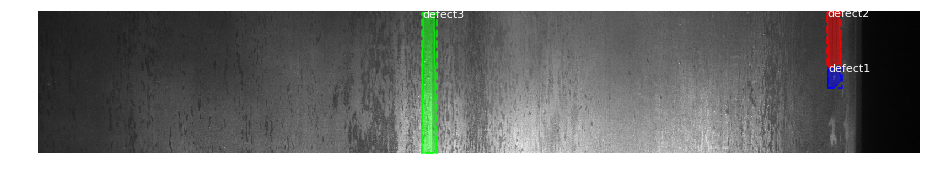

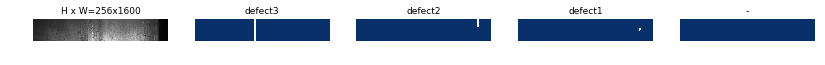

image_id  1 ../input/severstal-steel-defect-detection/train_images//db4867ee8.jpg
image                    shape: (256, 1600, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 3)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    3.00000  int64
bbox                     shape: (3, 4)                min:    0.00000  max: 1418.00000  int32


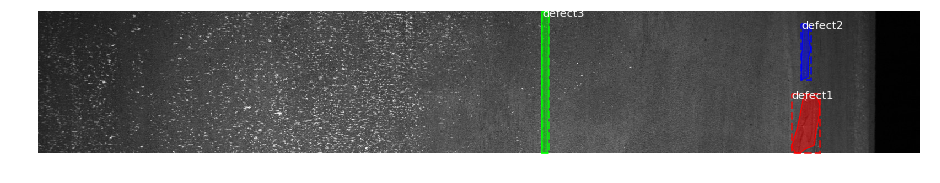

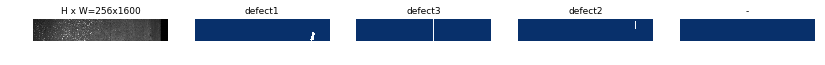

image_id  2 ../input/severstal-steel-defect-detection/train_images//a28a7b7be.jpg
image                    shape: (256, 1600, 3)        min:   30.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 10)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (10,)                 min:    1.00000  max:    3.00000  int64
bbox                     shape: (10, 4)               min:    3.00000  max: 1487.00000  int32


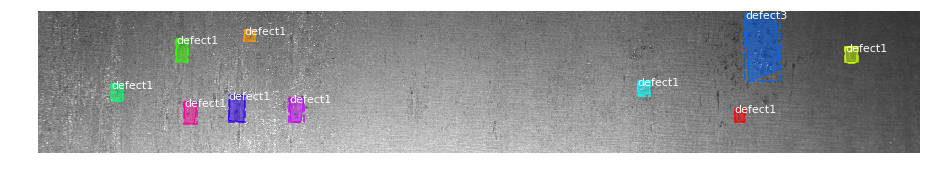

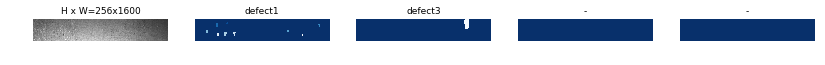

image_id  3 ../input/severstal-steel-defect-detection/train_images//c44784905.jpg
image                    shape: (256, 1600, 3)        min:   10.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 9)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (9,)                  min:    3.00000  max:    4.00000  int64
bbox                     shape: (9, 4)                min:    0.00000  max: 1504.00000  int32


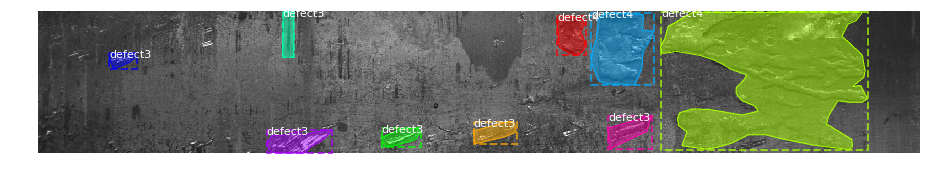

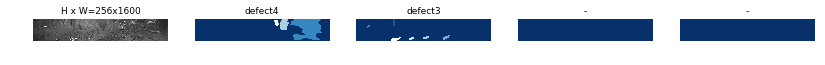

In [6]:
# Load example images and masks.
files = ['ef24da2ba.jpg', 'db4867ee8.jpg', 'a28a7b7be.jpg', 'c44784905.jpg']
dataset = SteelDataset()
dataset.load_steel(ROOT_DIR, files)
dataset.prepare()

image_ids = [0,1,2,3] 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Training
Mask R-CNN is a fairly large model. Especially that the Matterport implementation uses ResNet101 and FPN. Therefore using a GPU is recommended.

In [7]:
# select files for test and validation dataset
# Load annotations CSV
annotations_train = pd.read_csv(ROOT_DIR + 'train.csv')

# Remove images without Encoding
annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        

# Split ImageId_ClassId
ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]

# Split dataframe
msk = np.random.rand(len(annotations_train_Encoded)) < 0.85
train_msk = annotations_train_Encoded[msk]
val_msk = annotations_train_Encoded[~msk]
train = train_msk['ImageId'].unique().copy()
val = val_msk['ImageId'].unique().copy()
print('Test images: ' + str(len(train)))
print('Val images: ' + str(len(val)))
# Cleanup
del annotations_train, ImageId_ClassId_split, annotations_train_Encoded, msk, train_msk, val_msk 
gc.collect()

Test images: 5719
Val images: 1060


46634

In [8]:
# Training preperations
# Training dataset
dataset_train = SteelDataset()
dataset_train.load_steel(ROOT_DIR, train)
dataset_train.prepare()

# Validation dataset
dataset_val = SteelDataset()
dataset_val.load_steel(ROOT_DIR, val)
dataset_val.prepare()

# Build training model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []
# Load weights to continue training
# model.load_weights(Trained_Weights, by_name=True)

In [9]:
# Train model
timestart = timeit.default_timer()
print("Training")
model.train(dataset_train, 
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=config.EPOCHS,
            layers='all')
timestop = timeit.default_timer()
runtime = np.round((timestop - timestart) / 60, 2)
print ('Total run time: ' + str(runtime) + ' minutes')

Training

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/steel20191023T1255/mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 1/3
100/100 [==============================] - 498s 5s/step - loss: 7.3940 - val_loss: 1.4194
Epoch 2/3
100/100 [==============================] - 467s 5s/step - loss: 2.2741 - val_loss: 6.6824
Epoch 3/3
100/100 [==============================] - 475s 5s/step - loss: 2.4087 - val_loss: 1.7290
Total run time: 26.95 minutes


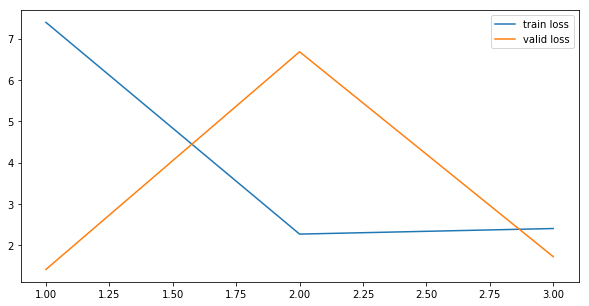

In [10]:
# Plot loss
history = model.keras_model.history.history
epochs = range(1,config.EPOCHS + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.show()